# **Classroom Attendance System Design using Deep Learning Principles**
### **Université Côte d'Azur**
### **MSc - Data Science and Artificial Intelligence**
### **Deep Learning Project**
### **Gaurav Khanal | 31 March 2025**

-------

# **INTRODUCTION**

This project proposes a Deep Learning (DL)-based pipeline to automatically detect, recognize, and log student attendance from a classroom image. The approach leverages state-of-the-art convolutional neural networks (CNNs) and face recognition models to:

1. Detect and segment faces in the image (localizing each individual).

2. Extract facial features for identity recognition.

3. Match detected faces against a pre-registered database to mark attendance.


## **Key Steps in the DL Pipeline**

1. Face Detection – Using a pre-trained model vision model locate and extract faces from the classroom image.

2. Face Recognition – Employing a deep metric learning model to generate unique embeddings for each face.

3. Database Matching – Comparing the extracted embeddings against a pre-stored database of enrolled students using multi-layer perceptron.

4. Attendance Logging – Recording recognized identities in an attendance sheet.

For the DL approach, we will be utilizing some key computer vision pretrained models. Some these models are used for different items

## **Pretrained Vision Models**

We will be utilizing the following pretrained models in this project:

1. `MTCNN` (Multi-Task Cascaded Convolutional Networks)
  - Purpose: Face detection and alignment (keypoint localization)
  - Key Features:
    - Three-stage CNN pipeline: Proposal, Refine, Output
    - Detects faces at multiple scales
    - Facial landmark detection
  - Use:
    - In this project, `MTCNN` will be used to obtain bounding boxes for our LFW subset.

2. `YOLOv8` (You Only Look Once version 8)
  - Purpose: Real-time object detection (including face detection)
  - Key Features:
    - Detects multiple faces in an image/video frame simultaneously
    - Extremely fast processing suitable for real-time applications
    - Good balance between accuracy and speed
  - Use:
    - We will fine-tune and detect faces in simulated classrooms using this model.

2. `ResNet18` (Residual Network 18-layer)
  - Purpose: Image classification/feature extraction
  - Key Features:
    - CNN architecture with residual connections (helps train deeper networks)
    - 18-layer version is relatively lightweight
    - Good for extracting facial features when retrained on faces
  - Use:
    - We will this model to classify gender of the detected face.

3. `FaceNet`
  - Purpose: Face recognition and verification
  - Key Features:
    - Uses triplet loss to create 128-dimensional face embeddings
    - Directly maps faces to a compact Euclidean space
    - State-of-the-art recognition accuracy
  - Use:
    - We will use this model to identify faces.

### **METADATA**

Due to privacy concerns associated with real classroom photos, we constructed a synthetic dataset by combining subsampled face images from the Labeled Faces in the Wild (`LFW`) dataset with artificially generated classroom backgrounds. This approach allows us to simulate realistic classroom scenarios while maintaining ethical data usage. Refer more to the "Ethical Concerns" section of the scientific paper for discussion on the ethical consideration of building an attendance system.

#### **Dataset Construction**

We have several steps for dataset construction based on the pipeline. We require datasets for 3 primary steps:

1. Face Detection (`YOLOv8`)
2. Gender Recognition (`ResNet18`)
3. Face Identification (`FaceNet`)

##### **`YOLOv8` Dataset**

We created the dataset for Face Detection by following the steps below:

1. **Subsampling LFW for Student Identities**
  - Selected ~20 individuals from LFW to represent "students" in the class
  - Manually created gender labels for the subsample (which is needed for gender classification step)
  - Ensured each identity had multiple high-quality images (frontal/semi-frontal faces)
  - Used MTCNN (Multi-Task Cascaded CNN) for face detection and alignment to extract consistent, cropped face regions
2. **Generating Synthetic Classroom Images**
  - Collected classroom background images (empty lecture halls, seminar rooms) from open-source datasets (refer to the scientific paper for details)
  - Crop the photos from the LFW photos (face only) to be able to paste in the classroom background.
  - For each background, randomly pasted 3 to 7 faces from the cropped LFW set to simulate varying attendance scenarios
  - Applied random transformations to improve realism
    - Scaling & Rotation: Slight variations in face size and angle
    - Lighting Adjustments: Simulating different classroom lighting conditions
    - Occlusion Simulation: Minor obstructions (e.g., partial face visibility) to mimic real-world challenges
  - Generated ~100 synthetic classroom images (with 3-7 faces in each) with labeled face positions and saved in a folder.
3. **Labeling and Ground Truth**
  - Each synthetic image includes annotations.
4. **Data Splits**
  - Once synthetic data are created, we proceeded to create the YOLOv8 dataset.
  - YOLOv8 has specific format requirements, so we converted the images to that format.
  _ Train-Test split (80:20): we split the images to train and test with 80% being used to fine tune the `YOLOv8` model. Respective train and test folders were created to save the photos as required by YOLOv8.

Once the data was ready, we created a yaml script with the directory paths to run the `YOLOv8` model. Refer below to the code. Also, for dataset preparationb for Gender Classification and Face Identification, refer to the respective sections beloww





First, we start my importing all the relevant libraries for this project, mount the google drive and define some key directories and mount Google Drive when working in `Colab`.

In [ ]:
# Import relevant libraries and packages
import os
import json
import uuid
import random
import glob
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image, ImageFilter, ImageDraw
from collections import Counter
from sklearn.datasets import fetch_lfw_people
from facenet_pytorch import MTCNN
import torch
from shutil import copy2
from ultralytics import YOLO
from pathlib import Path
import cv2
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler, random_split
import torchvision.models as models
from sklearn.model_selection import StratifiedShuffleSplit
import pytorch_lightning as pl
from pathlib import Path
import shutil
import torch.nn as nn
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay)
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
from facenet_pytorch import InceptionResnetV1
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import IMG_EXTENSIONS, default_loader
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **FACE DETECTION**

The first part of the project is face detection (segmentation). Face detection is a computer vision technology that identifies and locates human faces in digital images or videos. In our classroom attendance system, this serves as the crucial first step before we can perform gender classification or identity recognition. Traditional face detection methods like Haar cascades or HOG + SVM have limitations. Deep Learning-based methods offer:

* Higher accuracy (especially in challenging conditions)
* Better handling of variations in face appearance
* End-to-end learning without manual feature engineering

Hence, we will first create the dataset for `YOLOv8`.


## **Dataset Preparation**

In [ ]:
# Define directories
data_dir = "/content/drive/MyDrive/case_study/DataLFW"
background_dir = os.path.join(data_dir, "backgrounds", "classrooms")
sim_output_dir = os.path.join(data_dir, "SimulatedData")
bounding_box_file = os.path.join(sim_output_dir, "bounding_boxes.json")
gender_labels_file = os.path.join(sim_output_dir, "gender_labels.json")

os.makedirs(data_dir, exist_ok=True)
os.makedirs(background_dir, exist_ok=True)
os.makedirs(sim_output_dir, exist_ok=True)

### **Load `LFW` Data and Subsample**

In [ ]:
# Load LFW Dataset and subsample 20 individuals
lfw = fetch_lfw_people(min_faces_per_person=10, resize=1.0)

# Extract metadata
names = lfw.target_names
labels = lfw.target
counts = Counter(labels)

# Filter for more samples
qualified_indices = [i for i, c in counts.items() if c >= 15]
selected_names = [names[i] for i in qualified_indices][:20]

# Create directory substructure
for name in selected_names:
    os.makedirs(os.path.join(data_dir, name.replace(" ", "_")), exist_ok=True)

# Save Filtered Images
for img, label in tqdm(zip(lfw.images, lfw.target), total=len(lfw.images), desc="Saving images"):
    person = names[label]
    if person in selected_names:
        path = os.path.join(data_dir, person.replace(" ", "_"))
        img_pil = Image.fromarray((img * 255).astype("uint8"))
        img_pil.save(os.path.join(path, f"{uuid.uuid4().hex}.jpg"))

Saving images:   0%|          | 0/4324 [00:00<?, ?it/s]

### **Create Gender Labels**

We noticed that the LFW data is dominated by male identities. Even out of the 20 identities, we only have 4 females. In order to ensure class balance for face detection as well as for use in gender classification later, we define the gender labels below. We could have gone a bit further and obtain the genders using some DL model, but for now, we are hardcoding the genders based on information known. Also, refer to the "Ethical Considerations" section of the scientific paper where we discuss the ethical implications of gender classification.

In [ ]:
# Define gender labels
gender_labels = {
    "Abdullah_Gul": "male",
    "Alvaro_Uribe": "male",
    "Andy_Roddick": "male",
    "Ariel_Sharon": "male",
    "Atal_Bihari_Vajpayee": "male",
    "Bill_Simon": "male",
    "Colin_Powell": "male",
    "Dominique_de_Villepin":
    "male", "George_W_Bush": "male",
    "Gerhard_Schroeder": "male",
    "Gloria_Macapagal_Arroyo": "female",
    "Jacques_Chirac": "male",
    "John_Kerry": "male",
    "Jose_Maria_Aznar": "male",
    "Lindsay_Davenport": "female",
    "Mohammed_Al-Douri": "male",
    "Serena_Williams": "female",
    "Vladimir_Putin": "male",
    "Winona_Ryder": "female",
    "Silvio_Berlusconi": "male"
}

# Save labels as json file
with open(gender_labels_file, "w") as f:
    json.dump(gender_labels, f, indent=2)

### **Obtain Bounding Box Data**

Now that we have our data, we perform face detection on the subset of the LFW dataset in order to obtain the bounding boxes for the images. Note that this is not the actual face detection task we are tasked to perform. This is needed in order to create simulated classroom photos. We will also use the bounding box data obtained for the actual face detection step later. Note that this was also chosen to be done to prevent the YOLOv8 model to know its own bounding boxes.

In [ ]:
# Initialize MTCNN and bounding box data
mtcnn = MTCNN(keep_all=False, device=device)
bbox_data = {}

# Get all image paths first for accurate progress tracking
all_image_paths = []
for person_folder in tqdm(os.listdir(data_dir), desc="Scanning folders"):
    person_path = os.path.join(data_dir, person_folder)
    if os.path.isdir(person_path):
        for img_file in os.listdir(person_path):
            if img_file.lower().endswith('.jpg'):
                all_image_paths.append(os.path.join(person_path, img_file))

# Perform face detection and obtain bounding box data
for img_path in tqdm(all_image_paths, desc="Detecting faces"):
    try:
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            boxes, _ = mtcnn.detect(img)
            if boxes is not None:
                # Store path as string for JSON compatibility
                bbox_data[img_path] = boxes[0].tolist()
    except Exception as e:
        print(f"\nError processing {img_path}: {e}")
        continue

# Save results
with open(bounding_box_file, "w") as f:
    json.dump(bbox_data, f, indent=2)

print(f"Face detection complete. Detected {len(bbox_data)} faces out of {len(all_image_paths)} images.")

Scanning folders:   0%|          | 0/26 [00:00<?, ?it/s]

Detecting faces:   0%|          | 0/8536 [00:00<?, ?it/s]

Face detection complete. Detected 7618 faces out of 8536 images.


### **Create Synthetic Classroom Images**

Now that we have our subsample of LFW identities and their respective bounding boxes, we are ready to create the simulated classroom photos. Note that the good thing about using LFW dataset is that most of the photos are already in portrait type, so it is easy to paste these photos into backgrounds of classrooms. We first define some of the key configurations needed for this step. We will create 300 simulated images.

In [ ]:
# Define simulation configurations
sim_config = {
    "face_base": data_dir,
    "bg_base": background_dir,
    "output_dir": sim_output_dir,
    "output_size": (640, 480),
    "num_images": 300,
    "faces_per_image": (3, 7),
    "apply_blur": True,
    "background_ext": ".jpg",
    "face_scale_range": (0.1, 0.3),
    "rotation_range": (-15, 15),
    "blur_chance": 0.3,
    "blur_radius_range": (0.5, 1.5)
}

In order to prevent overlapping of photos when they are pasted onto the classroom background images, we first calculate the intersection over union (IoU) of the images / bounding boxes and then apply a threshold by which the simulated pictures are created. In essence, we are trying to spread out the images of the people in the classroom so that they don't overlap. We first define the functions below.

In [ ]:
# Define function to compute how much two bounding boxes overlap relative to their combined area
# i.e., Intersection over Union (IoU)
def calculate_iou(box1, box2):
    # Find intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    # Calculate intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    # Calculate individual areas
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    # Compute IoU
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0

In [ ]:
# Define function to check if a new bounding box significantly overlaps with any existing boxes
def has_overlap(bbox, existing_bboxes, threshold=0.01):
    return any(calculate_iou(bbox, b) > threshold for b in existing_bboxes)

In [ ]:
# Collect face image paths
face_paths = []
for person in os.listdir(data_dir):
    person_path = os.path.join(data_dir, person)
    if os.path.isdir(person_path):
        for img_file in glob.glob(os.path.join(person_path, "*.jpg")):
            face_paths.append((img_file, person))

# Collecting Background Image Paths
bg_paths = [os.path.join(background_dir, f)
            for f in os.listdir(background_dir)
            if f.lower().endswith(sim_config["background_ext"])]

if not bg_paths:
    raise ValueError("No background images found. Please upload at least one.")

We will now split the collected face image paths into separate lists for male and female faces, which is in particular useful for gender-balanced dataset creation or analysis. As noted before, our dataset is extremely unbalanced, so we will need to ensure class balance, which is why we have to identify the genders here. This will be used for fine-tuning purposes. The gender classification here is performed using the `gender_labels` data we created earlier. We are creating this distinction so that we can paste equitable number of male and female images in the classroom.

In [ ]:
# Split face_paths into male and female lists

# Initialization
female_faces = []
male_faces = []

# Gender classification
for path, label in face_paths:
    gender = gender_labels.get(label, "male")  # default to male
    if gender == "female":
        female_faces.append((path, label))
    else:
        male_faces.append((path, label))

# Sanity check
if not female_faces:
    raise ValueError("No female faces found. Cannot oversample females.")
if not male_faces:
    raise ValueError("No male faces found.")

Now, we defines the target proportion of female faces in the final set of synthetic images (60% female, 40% male in this case) for balancing gender representation in a dataset by oversampling female faces.

In [ ]:
# Set female oversampling ratio
female_ratio = 0.6

# Initialize male and female statistics
total_female = 0
total_male = 0

Now we need to generate synthetic images containing multiple faces with controlled gender ratios, while applying various augmentations and tracking annotations. The code below provides a comprehensive process where we attempt to balance classes as well as add diversity by adding augmentations (resize, rotate, optional blur), synthetic occlusions.

In [ ]:
# Initialization
annotations = {}

# Face selection
for img_idx in tqdm(range(sim_config["num_images"])):
    num_faces = random.randint(*sim_config["faces_per_image"])
    num_female = int(num_faces * female_ratio)
    num_male = num_faces - num_female

    # Sample females (if needed)
    selected_females = random.choices(female_faces, k=num_female) if len(female_faces) < num_female \
                       else random.sample(female_faces, num_female)

    # Sample males (no replacement)
    if len(male_faces) < num_male:
        continue
    selected_males = random.sample(male_faces, num_male)

    # Combine and shuffle selections for natural arrangement
    selected_faces = selected_females + selected_males
    random.shuffle(selected_faces)

    # Create background canvas
    bg_path = random.choice(bg_paths)
    bg = Image.open(bg_path).convert("RGBA").resize(sim_config["output_size"])
    canvas = bg.copy()
    image_bboxes = []

    for face_path, label in selected_faces:
        try:
            face = Image.open(face_path).convert("RGBA")

            # Resize
            scale = random.uniform(*sim_config["face_scale_range"])
            face_size = int(sim_config["output_size"][0] * scale)
            face = face.resize((face_size, face_size))

            # Rotate
            face = face.rotate(random.uniform(*sim_config["rotation_range"]), expand=True)

            # Optional blur
            if sim_config["apply_blur"] and random.random() < sim_config["blur_chance"]:
                face = face.filter(ImageFilter.GaussianBlur(
                    radius=random.uniform(*sim_config["blur_radius_range"])))

            # Occlusion
            if random.random() < 0.3:
                draw = ImageDraw.Draw(face)
                occ_w = int(face.width * random.uniform(0.2, 0.4))
                occ_h = int(face.height * random.uniform(0.1, 0.3))
                occ_x = random.randint(0, face.width - occ_w)
                occ_y = random.randint(0, face.height - occ_h)
                draw.rectangle([occ_x, occ_y, occ_x + occ_w, occ_y + occ_h],
                               fill=(0, 0, 0, 180))

            # Positioning
            max_x = sim_config["output_size"][0] - face.size[0]
            max_y = sim_config["output_size"][1] - face.size[1]
            if max_x <= 0 or max_y <= 0:
                continue

            # Intelligent placement
            for attempt in range(10):
                x = random.randint(0, max_x)
                y = random.randint(0, max_y)
                bbox = [x, y, x + face.size[0], y + face.size[1]]

                if not has_overlap(bbox, [b["bbox"] for b in image_bboxes]):
                    canvas.paste(face, (x, y), face)
                    image_bboxes.append({"label": label, "bbox": bbox})
                    # Count gender
                    if gender_labels[label] == "female":
                        total_female += 1
                    else:
                        total_male += 1
                    break

        except Exception as e:
            print(f"Skipping {face_path}: {e}")
            continue

    if not image_bboxes:
        continue

    # Save composite image and record face positions
    image_name = f"sim_{img_idx:03d}.jpg"
    image_path = os.path.join(sim_output_dir, image_name)
    canvas.convert("RGB").save(image_path)
    annotations[image_name] = image_bboxes

  0%|          | 0/300 [00:00<?, ?it/s]

Skipping /content/drive/MyDrive/case_study/DataLFW/SimulatedData/sim_065.jpg: 'SimulatedData'
Skipping /content/drive/MyDrive/case_study/DataLFW/SimulatedData/sim_023.jpg: 'SimulatedData'
Skipping /content/drive/MyDrive/case_study/DataLFW/SimulatedData/sim_043.jpg: 'SimulatedData'
Skipping /content/drive/MyDrive/case_study/DataLFW/SimulatedData/sim_025.jpg: 'SimulatedData'
Skipping /content/drive/MyDrive/case_study/DataLFW/SimulatedData/sim_002.jpg: 'SimulatedData'
Skipping /content/drive/MyDrive/case_study/DataLFW/SimulatedData/sim_026.jpg: 'SimulatedData'
Skipping /content/drive/MyDrive/case_study/DataLFW/SimulatedData/sim_048.jpg: 'SimulatedData'


In [ ]:
# Save annotations in a json file
annotations_path = os.path.join(sim_output_dir, "annotations.json")
with open(annotations_path, "w") as f:
    json.dump(annotations, f, indent=2)

In [ ]:
# Print summary
print(f"Done. {len(annotations)} images saved to '{sim_output_dir}'")
print(f"Total female faces: {total_female}")
print(f"Total male faces: {total_male}")
female_pct = (total_female / (total_female + total_male)) * 100
print(f"Female face percentage: {female_pct:.2f}%")

Done. 300 images saved to '/content/drive/MyDrive/case_study/DataLFW/SimulatedData'
Total female faces: 677
Total male faces: 634
Female face percentage: 51.64%


Now we have created only 300 the simulated pictures of classroom. Note that there were 3 classroom background photos used downloaded from the open source website [`Pexels`](https://www.pexels.com/search/classroom/). All images on `Pexels` offers professional-grade, high-resolution images — perfect for simulations that need realism. Furthermore, photos in `Pexels` are free to use, even commercially — no attribution required. You don’t risk copyright issues in your project or report.

### **`YOLOv8` Dataset Preprocessing**

Now that we have created the simulated pictures, we need to get it ready for `YOLOv8`, which requires specifications, so we perform the following steps:

Hence, we followed the following steps:
1. Split the simulated images into train/val sets (80/20).
2. Convert the bounding boxes (obtained from `MTCNN` to `YOLO` format (normalized `xywh`).
3. Use gender as class labels (female=0, male=1).
4. Organize into `YOLOv8` directory structure.


In [ ]:
# Define paths
annotation_file = "/content/drive/MyDrive/case_study/DataLFW/SimulatedData/annotations.json"
output_base = "/content/drive/MyDrive/case_study/DataLFW/yolo_dataset"

# Define split ratio
train_split = 0.8

In [ ]:
# Load annotation and gender label data
with open(annotation_file, "r") as f:
    annotations = json.load(f)

with open(gender_labels_file, "r") as f:
    gender_labels = json.load(f)

# Prepare image list and shuffle for train/val split
image_names = list(annotations.keys())
random.shuffle(image_names)
split_index = int(len(image_names) * train_split)

In [ ]:
# Create YOLOv8 directory structure
for subset in ['train', 'val']:
    os.makedirs(os.path.join(output_base, "images", subset), exist_ok=True)
    os.makedirs(os.path.join(output_base, "labels", subset), exist_ok=True)

# Loop through and process
for i, image_name in enumerate(tqdm(image_names)):
    subset = "train" if i < split_index else "val"

    img_path = os.path.join(sim_output_dir, image_name)
    label_path = os.path.join(output_base, "labels", subset, image_name.replace(".jpg", ".txt"))
    img_output_path = os.path.join(output_base, "images", subset, image_name)

    try:
        img = Image.open(img_path)
        w, h = img.size

        with open(label_path, "w") as f_out:
            for ann in annotations[image_name]:
                x_min, y_min, x_max, y_max = ann["bbox"]
                label = ann["label"]

                # Determine class ID based on gender
                gender = gender_labels.get(label, "male")
                class_id = 0 if gender == "female" else 1  # female=0, male=1

                x_center = ((x_min + x_max) / 2) / w
                y_center = ((y_min + y_max) / 2) / h
                box_width = (x_max - x_min) / w
                box_height = (y_max - y_min) / h

                f_out.write(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

        copy2(img_path, img_output_path)

    except Exception as e:
        print(f"Skipping {image_name}: {e}")

print(f"YOLOv8 dataset with gender classes created at: {output_base}")

  0%|          | 0/300 [00:00<?, ?it/s]

YOLOv8 dataset with gender classes created at: /content/drive/MyDrive/case_study/DataLFW/yolo_dataset


### **`YOLOv8` Configuration**

Now that we have prepared our dataset, we need to get it ready for `YOLOv8`, which requires specifications in a yaml format that has the followig setup. Dataset is configured using a `yaml` file that has the following information:
- Specifies paths to your `train`, `val`, and/or `test` image directories.
- Defines the number of classes and their names.

In [ ]:
# Define paths
yaml_path = os.path.join(output_base, "dataset.yaml")
train_images = os.path.join(output_base, "images", "train")
val_images = os.path.join(output_base, "images", "val")
output_crop_dir = os.path.join(output_base, "cropped_faces_for_gender")
os.makedirs(output_crop_dir, exist_ok=True)

In [ ]:
# Write YOLOv8 config in yaml
yaml_content = f"""path: {output_base}
train: images/train
val: images/val

nc: 2
names: ['female', 'male']
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content.strip())

In [ ]:
# Verify yaml
print(f"YOLOv8 config saved to:\n{yaml_path}")
print("Config content preview:")
print(yaml_content)

YOLOv8 config saved to:
/content/drive/MyDrive/case_study/DataLFW/yolo_dataset/dataset.yaml
Config content preview:
path: /content/drive/MyDrive/case_study/DataLFW/yolo_dataset
train: images/train
val: images/val

nc: 2
names: ['female', 'male']



## **Fine-tune `YOLOv8` for Face Detection**

Now we have prepared the dataset as well as the necessary `yaml` file for `YOLOv8`. The following represents some key details about the `YOLOv8` model:

1. Data Loading: Images are loaded in batches (default batch size of 16-64 depending on GPU memory) from disk or real-time streams. The framework supports common formats (JPEG, PNG) and automatically handles image decoding.
2. Preprocessing: Each image undergoes several transformations:
  - Resizing to the model's input dimension (e.g., 640x640) while maintaining aspect ratio (letterbox padding)
  - Normalization (pixel values scaled to 0-1 range)
  - Optional augmentations during training (mosaic, random affine transforms, HSV adjustments)
3. Label Formatting: For training, annotations must be in YOLO format - each image has a corresponding .txt file with normalized bounding box coordinates (center_x, center_y, width, height) and class IDs. These are converted to tensors matching the model's output grid structure.
4. Batch Composition: The DataLoader stacks preprocessed images into 4D tensors (batch_size × channels × height × width) and labels into batched tensors for efficient GPU processing.
5. Model Input: During inference, raw images/tensors are fed directly to the model. For training, the framework automatically handles the pairing of images with their corresponding ground truth targets for loss calculation.

`YOLOv8`'s data pipeline is optimized for speed, with on-the-fly augmentation and smart caching mechanisms to minimize I/O bottlenecks during training. The input resolution is configurable, allowing trade-offs between accuracy and inference speed.

In [ ]:
# Define a path to save YOLO runs
drive_path = "/content/drive/MyDrive/case_study/yolo_models"
os.makedirs(drive_path, exist_ok=True)

Here, the `YOLOv8` model has the following configurations.

Base Training Options

| Parameter       | Default Value | Description                                                                 | Recommended for Face Detection       |
|-----------------|---------------|-----------------------------------------------------------------------------|--------------------------------------|
| `data`          | `yaml_path`   | Path to dataset YAML file                                                   | Must contain face class definitions  |
| `epochs`        | `100`         | Total training iterations                                                   | Increase to 150-200 for small datasets |
| `imgsz`         | `640`         | Input image size in pixels                                                  | 320 for speed, 1280 for accuracy    |
| `batch`         | `16`          | Images per batch                                                            | Reduce if GPU OOM occurs            |
| `name`          | `"exp"`       | Experiment name                                                             | Use descriptive names like "face_detector_v1" |
| `patience`      | `10`          | Early stopping epochs                                                       | Stops if no improvement             |
| `device`        | `None`        | Hardware device                                                             | `0` for GPU, `'cpu'` for CPU        |
| `pretrained`    | `True`        | Use pretrained weights                                                      | Essential for transfer learning     |



Advanced Training Options

| Parameter       | Example Value | Effect                                                                      | When to Use                         |
|-----------------|---------------|-----------------------------------------------------------------------------|-------------------------------------|
| `lr0`           | `0.01`        | Initial learning rate                                                       | Higher for scratch, lower for fine-tuning |
| `cos_lr`        | `True`        | Cosine learning rate scheduler                                              | Smoother convergence                |
| `augment`       | `True`        | Enable mosaic/mixup augmentations                                           | Disable for small datasets          |
| `flipud`        | `0.1`         | Vertical flip probability                                                   | Helps with profile faces            |
| `mixup`         | `0.1`         | Image mixing strength                                                       | Regularization for large datasets   |
| `copy_paste`    | `0.1`         | Occlusion simulation                                                        | Crowded face scenarios              |
| `single_cls`    | `True`        | Single-class mode                                                           | When only detecting faces           |
| `dfl_reg_max`   | `16`          | Bins for distribution focal loss                                            | Reduce to 8 for simpler tasks       |


In [ ]:
# Load YOLOv8 model
yolo_model = YOLO("yolov8n.pt")

# Train YOLOv8 model
results = yolo_model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,
    batch=16,
    name="face_detector_yolov8",
    patience=10,
    device=0,
    pretrained=True,
)

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.2.2+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/case_study/DataLFW/yolo_dataset/dataset.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=face_detector_yolov83, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cr

train: Scanning /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/labels/train... 259 images, 0 backgrounds, 0 corrupt: 100%|██████████| 259/259 [00:02<00:00, 88.87it/s] 


train: New cache created: /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/labels/val... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:01<00:00, 57.21it/s]


val: New cache created: /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/labels/val.cache
Plotting labels to runs/detect/face_detector_yolov83/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/face_detector_yolov83
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.31G     0.5547      2.451     0.9813         16        640: 100%|██████████| 17/17 [00:08<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         89        395      0.499      0.801      0.527      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.31G     0.5159      1.312     0.9115         20        640: 100%|██████████| 17/17 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         89        395      0.447      0.924      0.546      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.32G     0.4879     0.9891     0.9002         18        640: 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        395      0.508      0.776      0.712      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.32G     0.4694     0.8417     0.8926         22        640: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         89        395       0.83       0.84      0.886      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.32G     0.4348     0.7437     0.8714         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         89        395      0.795      0.813      0.905      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.32G      0.417      0.671     0.8692         24        640: 100%|██████████| 17/17 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         89        395      0.807      0.863      0.909      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.32G     0.4205     0.6324     0.8613         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         89        395      0.944      0.963      0.979      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.32G     0.3827     0.5917     0.8526         33        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         89        395      0.766      0.745      0.713      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.32G     0.3889     0.5877     0.8625         34        640: 100%|██████████| 17/17 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         89        395      0.951      0.955      0.974      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.32G     0.3964     0.5829     0.8559         23        640: 100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         89        395      0.962      0.956      0.974      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.32G     0.3731     0.5448     0.8533         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        395      0.937      0.969      0.976      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.32G     0.3616     0.5473     0.8587         12        640: 100%|██████████| 17/17 [00:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         89        395      0.972      0.966      0.984      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.32G     0.3345     0.4969     0.8362         28        640: 100%|██████████| 17/17 [00:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         89        395      0.866      0.923      0.976      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.32G     0.3541     0.4916     0.8487         25        640: 100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         89        395      0.941      0.975      0.982      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.32G     0.3404      0.482     0.8432         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         89        395      0.933       0.93      0.974      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.32G     0.3355     0.4696     0.8379         20        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         89        395      0.963      0.967      0.988      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.32G     0.3409     0.4652     0.8478         22        640: 100%|██████████| 17/17 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         89        395      0.987      0.981      0.993      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.32G     0.3248     0.4315     0.8339         20        640: 100%|██████████| 17/17 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         89        395      0.854      0.888      0.906       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.32G     0.3282     0.4299     0.8396         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         89        395      0.933      0.921      0.953      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.32G     0.3161     0.4227     0.8396         20        640: 100%|██████████| 17/17 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         89        395      0.959      0.977      0.983       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.32G     0.3159     0.4196     0.8465         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         89        395      0.936      0.934      0.968       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.32G      0.321     0.4157     0.8393         34        640: 100%|██████████| 17/17 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         89        395      0.979      0.967      0.987       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.32G     0.3251     0.4399     0.8443         22        640: 100%|██████████| 17/17 [00:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         89        395      0.974      0.979       0.99      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.32G     0.3148     0.4206     0.8405         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         89        395      0.872      0.903      0.933      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.32G     0.3064     0.4046     0.8358         20        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         89        395      0.983      0.972      0.988      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.32G     0.3044     0.4059     0.8402         23        640: 100%|██████████| 17/17 [00:04<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         89        395      0.962      0.959      0.985      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.32G     0.2921      0.369     0.8308         31        640: 100%|██████████| 17/17 [00:05<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         89        395      0.989       0.98      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.32G     0.2983      0.382     0.8322         37        640: 100%|██████████| 17/17 [00:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         89        395      0.965      0.983      0.992      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.32G     0.2821     0.3631     0.8345         23        640: 100%|██████████| 17/17 [00:05<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


                   all         89        395      0.949      0.972      0.991      0.983

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.32G     0.2813     0.3522     0.8291         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         89        395       0.96       0.96      0.992      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.32G     0.2967     0.3521     0.8363         38        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         89        395      0.979      0.984       0.99      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.32G     0.2831      0.345       0.83         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         89        395      0.967      0.958      0.986      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.32G     0.2856     0.3542     0.8327         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         89        395      0.977      0.967      0.986      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.32G     0.2743     0.3237     0.8286         34        640: 100%|██████████| 17/17 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         89        395      0.968      0.954      0.978      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.32G     0.2673     0.3153     0.8268         29        640: 100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         89        395       0.97      0.962      0.985      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.32G      0.271     0.3273       0.83         33        640: 100%|██████████| 17/17 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         89        395      0.971      0.973      0.991      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.32G     0.2668     0.3153     0.8199         18        640: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


                   all         89        395      0.972      0.977      0.988      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.32G     0.2771     0.3417     0.8348         35        640: 100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         89        395      0.896      0.898      0.934      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.32G     0.2794     0.3322      0.828         40        640: 100%|██████████| 17/17 [00:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         89        395      0.846      0.886      0.923      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.32G     0.2706     0.3161     0.8319         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         89        395      0.982       0.98      0.991      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.32G     0.2665      0.306     0.8321         37        640: 100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         89        395      0.981      0.981      0.993      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.32G     0.2675     0.3061     0.8241         41        640: 100%|██████████| 17/17 [00:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         89        395      0.985      0.962      0.989       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.32G     0.2584     0.3044     0.8252         14        640: 100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         89        395      0.972      0.983      0.993      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.32G     0.2627     0.3135     0.8247         33        640: 100%|██████████| 17/17 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         89        395      0.977       0.97      0.992      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.32G     0.2559     0.2922     0.8273         27        640: 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         89        395      0.986       0.98      0.989      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.32G     0.2469     0.2908     0.8258         29        640: 100%|██████████| 17/17 [00:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         89        395      0.962      0.967      0.982      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.32G     0.2519     0.2962     0.8267         34        640: 100%|██████████| 17/17 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        395      0.952      0.972      0.984       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.32G     0.2474     0.2795      0.823         23        640: 100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         89        395      0.976      0.982      0.991      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.32G     0.2437     0.2826     0.8261         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         89        395      0.964      0.976      0.988      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.32G     0.2473     0.2847     0.8153         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         89        395       0.96      0.967       0.99      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.32G     0.2387     0.2738     0.8193         21        640: 100%|██████████| 17/17 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         89        395      0.979      0.974      0.985      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.32G     0.2427     0.2833     0.8209         22        640: 100%|██████████| 17/17 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         89        395        0.9      0.896      0.974      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.32G     0.2479     0.2957     0.8322         20        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         89        395      0.952      0.957      0.988      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.32G     0.2469     0.2831     0.8201         33        640: 100%|██████████| 17/17 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         89        395      0.976      0.967      0.991      0.986
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 44, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



54 epochs completed in 0.107 hours.
Optimizer stripped from runs/detect/face_detector_yolov83/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/face_detector_yolov83/weights/best.pt, 6.2MB

Validating runs/detect/face_detector_yolov83/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.2.2+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


                   all         89        395      0.978       0.97      0.992      0.986
                female         89        199      0.961      0.992      0.993      0.989
                  male         88        196      0.994      0.949       0.99      0.984
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/face_detector_yolov83


In [ ]:
# Load Best Model
best_model_path = os.path.join(results.save_dir, "weights", "best.pt")
face_model = YOLO(best_model_path)

In [ ]:
# Copy ALL training artifacts (not just weights)
!cp -r "/content/runs/detect/face_detector_yolov8" "{drive_path}"

## **Evaluate YOLOv8 Model**

Now that we have finished fine-tuning the model, we will evaluate the model by detecting faces on our validation dataset.

In [ ]:
# Evaluate model on validation set
print("Evaluating model on validation set")
metrics = face_model.val()

Evaluating model on validation set
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.2.2+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/labels/val.cache... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


                   all         89        395      0.977       0.97      0.992      0.987
                female         89        199      0.961      0.991      0.993      0.991
                  male         88        196      0.994      0.949       0.99      0.984
Speed: 2.9ms preprocess, 8.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val


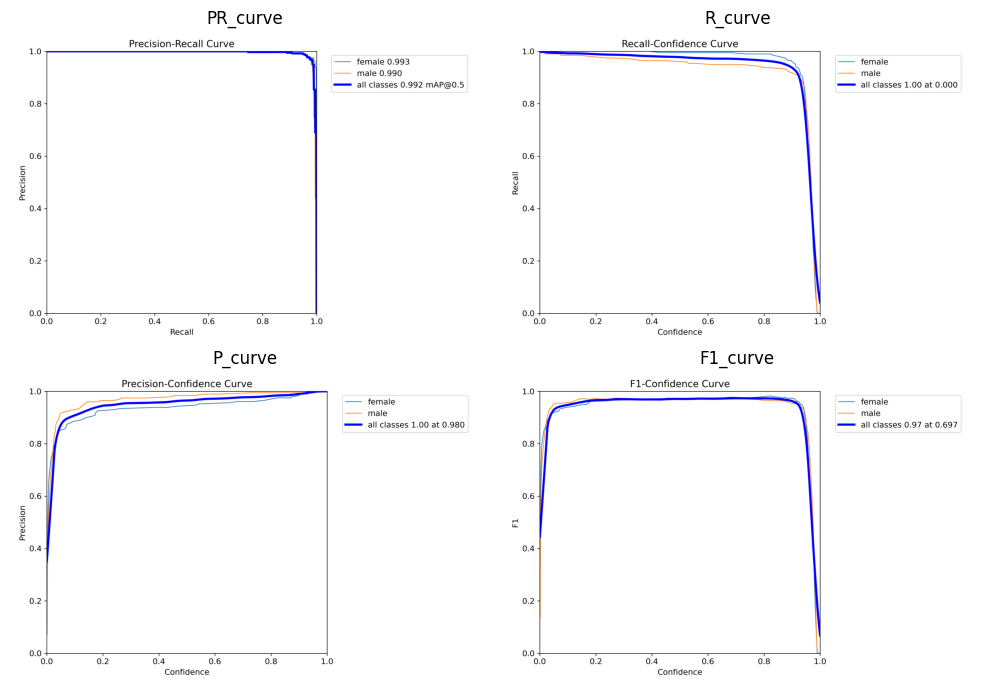

In [ ]:
# Visualize evaluation metrics
plot_files = [
    'PR_curve.png',
    'R_curve.png',
    'P_curve.png',
    'F1_curve.png'
]
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
for ax, plot_file in zip(axes.flat, plot_files):
    img_path = os.path.join(results.save_dir, plot_file)
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(plot_file.split('.')[0])
plt.tight_layout()
plt.show()

### **Evaluation Results**

As we can see above, based on the validation results, we make the following observations:
1. Excellent Overall Performance:
  - Near-perfect mAP50 (0.992) indicates outstanding detection accuracy
  - High recall (0.97) means minimal missed faces

2. Gender Performance:
  - Females: Higher recall (0.991 vs 0.949) but slightly lower precision
  - Males: Near-perfect precision (0.994) with slightly lower recall

3. Speed:
  - 11.6ms total latency per image → ~86 FPS (production-ready).

Now that we have completed the face detection, we will crop the detected faces and then perform gender classification on them.

# **GENDER CLASSIFICATION**

Now that we have successfully detected and localized faces in our images using YOLOv8, the next step is to analyze these cropped face regions for gender classification. By isolating each detected face, we ensure that the gender classification model receives standardized, high-quality inputs—free from background noise or partial obstructions—improving both accuracy and reliability. This two-stage pipeline (detection followed by classification) allows for modular optimization: while YOLOv8 excels at real-time face localization, a dedicated gender classifier can fine-tune predictions using focused facial features.

## **Gender Dataset Creation**

We will now extract the bounding box coordinates from our detection results, crop each face, and pass these regions through a pre-trained gender classification model to predict labels (male/female) with confidence scores. This approach not only refines our analysis but also enables granular performance evaluation for each component of the system.

In [ ]:
# Crop detected faces from the validation images
results = face_model.predict(source=val_images, conf=0.3, save=True)

for result in tqdm(results, desc="Cropping faces"):
    try:
        img_path = result.path
        img = cv2.imread(img_path)
        boxes = result.boxes.xyxy

        # Bounding box handling & cropping
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            if x1 < x2 and y1 < y2:
                cropped_face = img[y1:y2, x1:x2]
                # Save cropped faces
                out_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_face{i}.jpg"
                out_path = os.path.join(output_crop_dir, out_name)
                cv2.imwrite(out_path, cropped_face)

    except Exception as e:
        print(f"Error processing {result.path}: {e}")

print(f"Cropped faces saved to: {output_crop_dir}")


image 1/89 /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/images/val/sim_000.jpg: 480x640 3 females, 3 males, 71.2ms
image 2/89 /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/images/val/sim_004.jpg: 480x640 4 females, 4 males, 14.7ms
image 3/89 /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/images/val/sim_007.jpg: 480x640 2 females, 2 males, 15.7ms
image 4/89 /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/images/val/sim_008.jpg: 480x640 4 females, 3 males, 21.8ms
image 5/89 /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/images/val/sim_011.jpg: 480x640 3 females, 3 males, 14.0ms
image 6/89 /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/images/val/sim_012.jpg: 480x640 2 females, 3 males, 13.0ms
image 7/89 /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/images/val/sim_015.jpg: 480x640 3 females, 2 males, 13.5ms
image 8/89 /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/images/val/sim_017.jpg: 480x640 2 females, 3 males, 13.4ms

Cropping faces:   0%|          | 0/89 [00:00<?, ?it/s]

Cropped faces saved to: /content/drive/MyDrive/case_study/DataLFW/yolo_dataset/cropped_faces_for_gender


In [ ]:
# Define paths again
lfw_path = os.path.abspath("/content/drive/MyDrive/case_study/DataLFW")
gender_labels_path = "/content/drive/MyDrive/case_study/DataLFW/SimulatedData/gender_labels.json"
gender_dataset_path = os.path.join(lfw_path, "gender_dataset")

# Create directories
os.makedirs(gender_dataset_path, exist_ok=True)
os.makedirs(os.path.join(gender_dataset_path, "male"), exist_ok=True)
os.makedirs(os.path.join(gender_dataset_path, "female"), exist_ok=True)

Now, we need a training set for our gender classification. The orginal subset of the LFW dataset we used for Face Detection was not delineated into "male" and "female" genders; hence, we will now create a gender dataset based on the gender labels defined above using the image data from LFW subset.

In [ ]:
# Load gender labels
with open(gender_labels_path, "r") as f:
    gender_labels = json.load(f)

In [ ]:
# Copy LFW images to male/female folders
# Directory Processing
for person in tqdm(os.listdir(lfw_path), desc="Processing persons"):
    person_path = os.path.join(lfw_path, person)
    if not os.path.isdir(person_path) or person == "gender_dataset":
        continue
    # Gender Validation
    gender = gender_labels.get(person)
    if gender not in ["male", "female"]:
        continue
    target_dir = os.path.join(gender_dataset_path, gender)
    # Image Copying
    for img_name in os.listdir(person_path):
        src = os.path.join(person_path, img_name)
        dst = os.path.join(target_dir, f"{person}_{img_name}")
        if os.path.isfile(src):
            shutil.copy(src, dst)

print("Gender dataset created!")

Processing persons:   0%|          | 0/26 [00:00<?, ?it/s]

Gender dataset created!


Now that we have the images in the male and female folders, we will setup custom PyTorch dataset for loading and preprocessing gender-classified face images. We will create a `GenderDataset` class that:

1. Loads face images from gender-specific folders (`male/`, `female/`)
2. Applies optional transformations
3. Implements female-class image augmentation (for balancing datasets)
4. Provides standard dataset interface for PyTorch `DataLoader`.



In [ ]:
# Create gender dataset class
class GenderDataset(Dataset):
    # Initialization
    def __init__(self, data_dir, transform=None, augment_female=False):
        self.samples = []
        self.transform = transform
        self.augment_female = augment_female

        # Load images with gender labels
        for gender in ["male", "female"]:
            label = 0 if gender == "male" else 1
            gender_path = os.path.join(data_dir, gender)
            for img in tqdm(os.listdir(gender_path), desc=f"{gender} images"):
                img_path = os.path.join(gender_path, img)
                if os.path.isfile(img_path):
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples) # total number of samples

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")

        # Female-specific augmentation
        if self.augment_female and label == 1:
            image = self._augment_image(image)

        # Apply standard transforms
        if self.transform:
            image = self.transform(image)
        return image, label

    # Female Augmentation
    def _augment_image(self, image):
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.9),
            transforms.RandomRotation(20),
            transforms.ColorJitter(0.4, 0.4, 0.4),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2))
        ])(image)

In [ ]:
# Define PyTorch data transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Define dataset loading and train test
full_dataset = GenderDataset(gender_dataset_path, transform=transform, augment_female=True)
labels = [label for _, label in full_dataset]

male images:   0%|          | 0/7584 [00:00<?, ?it/s]

female images:   0%|          | 0/852 [00:00<?, ?it/s]

In [ ]:
# Print class distribution
print("Class distribution:", dict(zip(*np.unique(labels, return_counts=True))))

Class distribution: {0: 7584, 1: 852}


## **Gender Dataset Preprocessing**

As you can see above, our data is extremely imbalanced. We have 7,584 male data and just 852 female data. Hence, we will perform a few procedures that will help aleviate the effects of the data imbalance. We will perform the follwing:

1. Stratified Train-Test Split
2. Weighted Random Sampler

### **Stratified Train-Test Split**

A stratified train-test split is a method of splitting a dataset into training and testing subsets while preserving the original class distribution in both sets. This is crucial for imbalanced datasets (e.g., 70% male, 30% female) to ensure fair model evaluation. The method ensures both training and test sets have the same proportion of classes (e.g., 60% male, 40% female in both splits). Without stratification, random splitting might accidentally exclude rare classes from the test set. In addition, metrics like accuracy/precision/recall are more reliable when test data represents real-world class distribution.

The following code preserves the original class ratio:
* `n_splits=1`: Single split (train/val)
* `test_size=0.2`: 20% validation, 80% training
* `random_state=42`: reproducibility

In [ ]:
# Perform stratified train-test split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(split.split(np.zeros(len(labels)), labels))

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

### **Weighted Random Sampler**

A Weighted Random Sampler is a PyTorch utility that helps address class imbalance in datasets by assigning sampling weights to each class. It ensures that during training, underrepresented classes are sampled more frequently, leading to better model performance on minority classes.

Why use it?
- Balances imbalanced datasets
- Prevents model bias toward majority class
- Improves recall for minority classes
- Works with PyTorch `DataLoader`

How it works?
- Assigns a weight to each sample based on its class frequency.
- Samples data non-uniformly—underrepresented classes get higher weights.
- Ensures balanced batches during training.

We use the class `WeightedRandomSampler` in PyTorch to perform this task with the following parameters:
* `replacement=True`: Allows duplicate sampling of rare classes
* `num_samples=len(sample_weights)`: Maintains dataset size

In [ ]:
# Compute class weights for the loss function
class_counts = np.bincount(labels)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
class_weights /= class_weights.sum()
print(f"Class weights for loss: {class_weights}")

Class weights for loss: tensor([0.1010, 0.8990])


In [ ]:
# Utilize WeightedRandomSampler
train_labels = [full_dataset[i][1] for i in train_idx]
sample_weights = [1.0 / class_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## **Define Gender Classification Model**

Now we utilize `PyTorch Lightning` to define the gender classification model. We use this package as it is a lightweight wrapper for PyTorch that simplifies deep learning research by abstracting boilerplate code while maintaining full flexibility. It eliminates repetitive code, standardizes structure for reproducibility, and accelerates research without sacrificing PyTorch's flexibility.

We define the Lightning module that implements a `ResNet-18`-based gender classifier with:
* Transfer Learning: Pretrained on ImageNet for robust feature extraction
* Class Balancing: Weighted loss function to handle imbalanced datasets
* Automatic Metrics: Tracks training loss, validation loss, and accuracy
* Modular Design: Easy to swap backbones or modify for similar binary classification tasks


In [ ]:
# Define gender classification model
class GenderClassifier(pl.LightningModule):
    def __init__(self, class_weights=None):
        super().__init__()
        # Backbone: Pretrained ResNet18
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # Replace final layer for binary classification
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 2)
        # Loss function with class weighting
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    # Forward Pass
    def forward(self, x):
        return self.backbone(x)

    # Training Loop
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("train_loss", loss)
        return loss

    # Validation Loop
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        pred_labels = torch.argmax(preds, dim=1)
        acc = accuracy_score(y.cpu(), pred_labels.cpu())
        self.log_dict({"val_loss": loss, "val_acc": acc}, prog_bar=True)
        return loss

    # Optimizer Configuration
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

## **Train Gender Classification Model**

In [ ]:
# Load gender model
gender_model = GenderClassifier(class_weights=class_weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.1MB/s]


In [ ]:
# Define early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",               # Metric to monitor
    patience=3,                       # Wait 3 epochs without improvement
    mode="min",                       # Minimize val_loss
    verbose=True
)

In [ ]:
# Trainer configuration
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Use GPU
    logger=False,                                               # Disables TensorBoard
    callbacks=[early_stop_callback]
)

# Fit the model
trainer.fit(gender_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.040


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.000. Signaling Trainer to stop.


### **Evaluate the Gender Classification Model**

Now that we have fine-tuned the model, let's validate using the validation and test the model using the cropped images from the face detection model. We will run the model through the validation set using PyTorch Lightning's built-in validation, save the model, and perform a detailed evaluation of results.

In [ ]:
# Validate model
trainer.validate(gender_model, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.995853066444397     │
│         val_loss          │   0.006171094253659248    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.006171094253659248, 'val_acc': 0.995853066444397}]

In [ ]:
# Save model checkpoint
trainer.save_checkpoint("gender_classifier.ckpt")

Note that the `trainer.validate()` code above uses PyTorch Lightning’s built-in validation logic defined in the validation_step() method. It's purpose is quick validation during/after training to monitor progress, lightweight check for early stopping or checkpointing, etc. However, we want a detailed view of our predictions, so we will define a custom evaluation loop for detailed analysis beyond what `validation_step()` provides and for collecting all predictions/labels for additional metrics (e.g., per-class precision/recall, confusion matrix).

In [ ]:
# Detailed evaluation
gender_model.eval()
all_preds, all_labels = [], []

for x, y in tqdm(val_loader, desc="Predicting"):
    with torch.no_grad():
        y_hat = gender_model(x)
        preds = torch.argmax(y_hat, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(y.cpu().numpy())

Predicting:   0%|          | 0/53 [00:00<?, ?it/s]

In [ ]:
# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["male", "female"], zero_division=0))

Classification Report:
              precision    recall  f1-score   support

        male       1.00      1.00      1.00      1518
      female       0.96      1.00      0.98       170

    accuracy                           1.00      1688
   macro avg       0.98      1.00      0.99      1688
weighted avg       1.00      1.00      1.00      1688



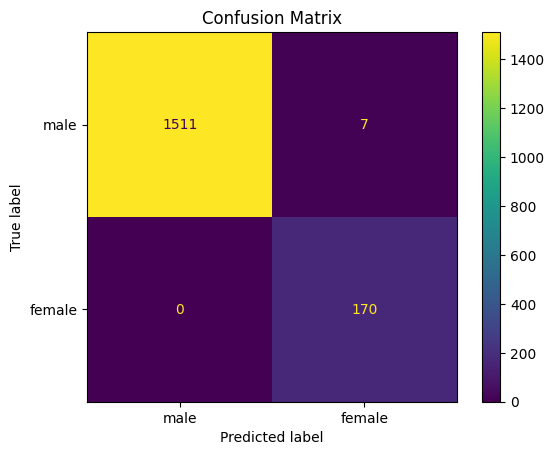

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=["male", "female"]).plot()
plt.title("Confusion Matrix")
plt.show()

As we see here, our gender classification model has also performed really well. Which is really great. Now, we move on to our (final) face identification section of our pipeline.

# **FACE IDENTIFICATION**

We now move from face detection and gender classification to face identification—the task of matching detected faces to specific individuals in a database. While FaceNet remains the gold standard for face recognition (using its compact 128-D embeddings and triplet loss for open-set scenarios), we’ll initially implement a ResNet-based classifier for simplicity in closed-set identification (where all individuals are known beforehand). This ResNet approach:

* Treats identification as a classification problem, mapping faces to known identities via a softmax head.
* Leverages transfer learning (ImageNet weights) for robust feature extraction.
* Is easier to train for small-scale deployments but less flexible than FaceNet for adding new identities dynamically.

For production systems, we’d later replace this with FaceNet’s embedding-based matching, which excels at scalability and handling unknown faces. For now, the ResNet classifier provides a practical starting point to build our pipeline.

In [ ]:
# Face Identification Configuration
data_dir = "/content/drive/MyDrive/case_study/DataLFW"
cropped_faces_dir = "/content/drive/MyDrive/case_study/DataLFW/yolo_dataset/cropped_faces_for_gender"
batch_size = 32        # Number of images processed per batch during training/inference
img_size = 160         # Input image dimensions (height and width in pixels)
num_workers = 2        # Number of CPU threads for parallel data loading
max_epochs = 30        # Maximum training iterations over the entire dataset
val_split = 0.2        # Fraction of data reserved for validation (here, 20%)
use_resnet50 = False   # Flag to choose between backbones

In [ ]:
# Define PyTorch transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
# Load gender label names
with open(os.path.join(data_dir, "SimulatedData", "gender_labels.json")) as f:
    gender_labels = json.load(f)

valid_classes = set(gender_labels.keys())

## **Dataset Preparation for Face Identification**

Due to our directory structure, we will need to define a custom dataset class `FilteredImageFolder` that extends PyTorch's built-in ImageFolder to selectively load only specific classes (subfolders) from a directory, based on a predefined list of valid classes (e.g., from `gender_labels.json`). This creates unique folders for the unique individuals.

In [ ]:
# Custom dataset
class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        # All subfolders
        all_classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        # Only keep classes present in gender_labels.json
        filtered = sorted([c for c in all_classes if c in valid_classes])
        class_to_idx = {cls_name: i for i, cls_name in enumerate(filtered)}
        return filtered, class_to_idx

In [ ]:
# Load data
dataset = FilteredImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

In [ ]:
# Check class names
print(class_names)

# Check no. of classes
print(f"\n Using {num_classes} identities from gender_labels.json")

['Abdullah_Gul', 'Alvaro_Uribe', 'Andy_Roddick', 'Ariel_Sharon', 'Atal_Bihari_Vajpayee', 'Bill_Simon', 'Colin_Powell', 'Dominique_de_Villepin', 'George_W_Bush', 'Gerhard_Schroeder', 'Gloria_Macapagal_Arroyo', 'Jacques_Chirac', 'John_Kerry', 'Jose_Maria_Aznar', 'Lindsay_Davenport', 'Mohammed_Al-Douri', 'Serena_Williams', 'Silvio_Berlusconi', 'Vladimir_Putin', 'Winona_Ryder']

 Using 20 identities from gender_labels.json


In [ ]:
# Split data
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Now, based on the data we sampled from the LFW dataset, we note that some individuals (e.g., George W Bush) has more images than others. In order to balance image classes, we will perform a weighted random sampling similar to above. Without it, the model may favor frequently seen faces, hurting performance on rare classes. It is also critical in small scale application like this one.

In [ ]:
# Class weights and sampler
train_labels = [dataset.samples[i][1] for i in train_dataset.indices]
class_counts = np.bincount(train_labels)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## **Fine-tune the Face Identification Model**

As mentioned earlier, we will be using ResNet for Face Identification. We have build the model as follows:

1. Backbone Selection:
  - Uses either ResNet50 or ResNet18 (pre-trained on ImageNet) as a feature extractor
  - Controlled by the `use_resnet50` flag (True/False)
  - Both models are initialized with ImageNet weights for transfer learning

2. Custom Head:
  - Reduces 2048/512 features (ResNet50/18) → 256 → num_classes
  - Dropout helps prevent overfitting

It also contains the usual forward pass, training logic, validation, and optimization configuration.

In [ ]:
# Define face identification / recognition model class
class FaceIDModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.save_hyperparameters()
        if use_resnet50:
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        else:
            self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return {"logits": logits, "y": y}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
# Define model
face_id_model = FaceIDModel(num_classes=num_classes)

Now, we define two essential PyTorch Lightning callbacks to optimize and safeguard the face identification training process. The `ModelCheckpoint` callback continuously monitors validation accuracy (val_acc), automatically saving the model weights whenever a new peak accuracy is achieved (keeping only the single best version as "best-faceid.ckpt"). Simultaneously, the `EarlyStopping` callback watches validation loss (val_loss), halting training if performance fails to improve for five consecutive epochs to prevent overfitting and computational waste.

In [ ]:
# Define callbacks
checkpoint_callback = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1, filename="best-faceid")
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True)

In [ ]:
# Define trainer
trainer2 = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=False
)

# Fit the model
trainer2.fit(face_id_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.3 M | train
1 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.252    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.347


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.283


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.235 >= min_delta = 0.0. New best score: 0.048


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.029


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.003. Signaling Trainer to stop.


## **Evaluate the Face Identification Model**

In [ ]:
# Validate the model
trainer2.validate(face_id_model, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9988144636154175     │
│         val_loss          │   0.014496106654405594    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.014496106654405594, 'val_acc': 0.9988144636154175}]

In [ ]:
# Evaluate
face_id_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        logits = face_id_model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
                         precision    recall  f1-score   support

           Abdullah_Gul       1.00      0.94      0.97        18
           Alvaro_Uribe       1.00      1.00      1.00        50
           Andy_Roddick       1.00      1.00      1.00        22
           Ariel_Sharon       0.99      1.00      0.99        95
   Atal_Bihari_Vajpayee       1.00      1.00      1.00        27
             Bill_Simon       1.00      1.00      1.00        22
           Colin_Powell       1.00      1.00      1.00       273
  Dominique_de_Villepin       1.00      1.00      1.00        14
          George_W_Bush       1.00      1.00      1.00       650
      Gerhard_Schroeder       1.00      1.00      1.00       113
Gloria_Macapagal_Arroyo       1.00      1.00      1.00        48
         Jacques_Chirac       1.00      1.00      1.00        65
             John_Kerry       1.00      1.00      1.00        21
       Jose_Maria_Aznar       0.95      1.00      0.98        21
 

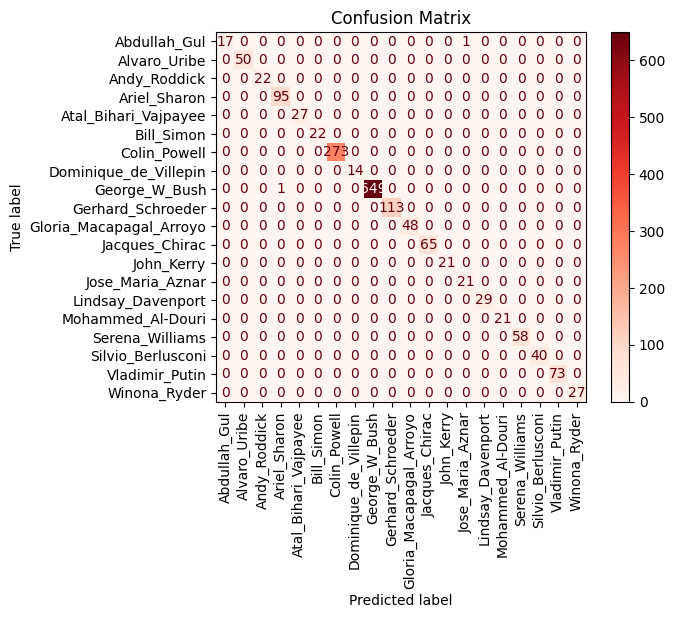

In [ ]:
# Print confusion matrix
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Reds", xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

Now that we have validated our model, we will identify the faces of the cropped photos from the Face Detection model. Refer to the code below:

In [ ]:
# Optimized Face Prediction Pipeline
def predict_faces(model, cropped_faces_dir, transform, class_names, batch_size=32, device='cuda'):
    """Batch-process face images for efficient prediction."""
    model.eval().to(device)
    predictions = []

    # Get sorted list of image paths (faster than os.listdir + filtering)
    img_paths = sorted([
        os.path.join(cropped_faces_dir, f)
        for f in os.listdir(cropped_faces_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    print(f"Found {len(img_paths)} face images for prediction")

    # Process in batches for maximum GPU utilization
    for i in tqdm(range(0, len(img_paths), batch_size), desc="🔍 Predicting identities"):
        batch_paths = img_paths[i:i+batch_size]
        batch_images = []

        # Load and transform all images in batch
        for path in batch_paths:
            try:
                img = Image.open(path).convert('RGB')
                batch_images.append(transform(img))
            except Exception as e:
                print(f"⚠️ Error loading {os.path.basename(path)}: {str(e)}")
                continue

        if not batch_images:
            continue

        # Stack and move to device
        batch_tensor = torch.stack(batch_images).to(device)

        # Batch prediction
        with torch.inference_mode():
            logits = model(batch_tensor)
            if isinstance(logits, list):
                logits = logits[0]
            probs = torch.softmax(logits, dim=1)
            scores, pred_idxs = torch.max(probs, dim=1)

        # Store results
        for path, pred_idx, score in zip(batch_paths, pred_idxs.cpu(), scores.cpu()):
            predictions.append({
                "image": os.path.basename(path),
                "identity": class_names[pred_idx.item()],
                "score": round(score.item(), 4)
            })

    return predictions

# Get predictions on cropped faces
predictions = predict_faces(
    model=face_id_model,
    cropped_faces_dir=cropped_faces_dir,
    transform=transform,
    class_names=class_names,
    batch_size=64  # Adjust based on GPU memory
)

Found 415 face images for prediction


🔍 Predicting identities:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
preds_df = pd.DataFrame(predictions)
preds_df.head(20)

,image,identity,score
0,sim_000_face0.jpg,Serena_Williams,0.6972
1,sim_000_face1.jpg,Winona_Ryder,0.9670
2,sim_000_face2.jpg,Serena_Williams,0.7644
3,sim_000_face3.jpg,George_W_Bush,1.0000
4,sim_000_face4.jpg,Gerhard_Schroeder,0.4045
5,sim_000_face5.jpg,Gloria_Macapagal_Arroyo,0.9997
6,sim_004_face0.jpg,Winona_Ryder,0.9999
7,sim_004_face1.jpg,Gloria_Macapagal_Arroyo,0.9111
8,sim_004_face2.jpg,Colin_Powell,0.9324
9,sim_004_face3.jpg,Colin_Powell,1.0000


# Attendance System Design

Now that we have trained and tested an end to end model (Face Detection, Gender Classificaiton, and Face Identification), we can utilized the best models we have trained and develop an attendance logging pipeline.

In [ ]:
# Load fine-tuned face detector (YOLOv8)
face_detector = YOLO("runs/detect/face_detector_yolov8/weights/best.pt")

In [ ]:
# Load fine-tuned gender classifer
gender_model = GenderClassifier.load_from_checkpoint("gender_classifier.ckpt")
gender_model.eval().to(device)

In [ ]:
# Load fine tuned face identifier
face_identifer = FaceIDModel.load_from_checkpoint('best-facenet.ckpt').to(device).eval()

In [ ]:
# Load Gallery Embeddings (from LFW identities)
gallery_npz = np.load("lfw_identity_gallery.npz", allow_pickle=True)
gallery = {k: torch.tensor(v, dtype=torch.float32).to(device) for k, v in gallery_npz.items()}
gallery_names = list(gallery.keys())
gallery_stack = torch.stack(list(gallery.values()))

In [ ]:
# Load Ground-Truth Genders
with open("DataLFW/gender_labels.json", "r") as f:
    gender_labels = json.load(f)

In [ ]:
# Transforms
transform_gender = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_face = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

Now, we will define a function that will process a classroom photo through the timeline of 1) face detection, 2) gender classification,  3) face identification and 4) attendance logging. The models used are the fine-tuned YOLOv8 for face detection and ResNet18 for gender classification and face identification/recognition. Once the faces are identified, an attendance log is filled out.

In [ ]:
def process_single_photo(image_path, output_dir=None):
    """Full pipeline for single photo processing"""
    # Initialize
    models = load_models()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = output_dir or f"attendance_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    # 1. Face Detection
    detections = models['face_detector'](image_path)[0]
    img = Image.open(image_path).convert('RGB')
    face_crops = []

    # Crop all detected faces
    for i, box in enumerate(detections.boxes.xyxy):
        x1, y1, x2, y2 = map(int, box.tolist())
        face_crops.append(img.crop((x1, y1, x2, y2)))

    if not face_crops:
        print("⚠️ No faces detected!")
        return None

    # 2. Batch Processing
    with torch.inference_mode():
        # Preprocess all faces
        face_tensors = torch.stack([transform_face(face) for face in face_crops]).to(DEVICE)
        gender_tensors = torch.stack([transform_gender(face) for face in face_crops]).to(DEVICE)

        # Get predictions
        gender_probs = torch.softmax(models['gender_model'](gender_tensors), dim=1)
        face_embs = models['facenet'](face_tensors)
        face_embs = torch.nn.functional.normalize(face_embs, p=2, dim=1)

        # Compare with gallery
        similarity_matrix = face_embs @ gallery_embeddings.T
        best_scores, best_indices = torch.max(similarity_matrix, dim=1)

    # 3. Generate Results
    results = []
    for i, (face, score, idx) in enumerate(zip(face_crops, best_scores, best_indices)):
        # Save face crop
        face_path = os.path.join(output_dir, f"face_{i}.jpg")
        face.save(face_path)

        # Get predictions
        gender = "male" if gender_probs[i][0] > GENDER_CONF_THRESH else "female"
        identity = gallery_names[idx] if score >= MIN_FACE_CONFIDENCE else "Unknown"

        results.append({
            'face_id': i,
            'image_path': face_path,
            'identity': identity,
            'confidence': round(score.item(), 4),
            'gender': gender,
            'gender_confidence': round(max(gender_probs[i]).item(), 4)
        })

    # 4. Create Attendance Log
    attendance = []
    for student in gallery_names:
        present = any(r['identity'] == student for r in results)
        attendance.append({
            'student': student,
            'present': int(present),
            'timestamp': timestamp
        })

    # Save outputs
    results_df = pd.DataFrame(results)
    attendance_df = pd.DataFrame(attendance)

    results_df.to_csv(os.path.join(output_dir, 'face_predictions.csv'), index=False)
    attendance_df.to_csv(os.path.join(output_dir, 'attendance.csv'), index=False)

    # Print summary
    print(f"\Detected {len(results)} faces:")
    print(results_df[['face_id', 'identity', 'confidence']])

    print(f"\n Attendance Summary:")
    print(attendance_df)

    print(f"\n Results saved to: {output_dir}")

    return results_df, attendance_df

In [ ]:
# Fill Attendance sheet
process_single_photo("classroom_simulated.jpg")

This way, we have created, trained, validated and tested an end-to-end attendance system using deep learning approach.